In [16]:
import pandas as pd
import math
df = pd.read_csv('Reviews_Oatmeal_Plain.csv')

import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

In [17]:
from lxml import html  
import requests
import nltk
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

cols = list(df.columns)

print(cols)

user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/62.0.3202.94 Safari/537.36'

col_dict = {}

lmtzr = WordNetLemmatizer()

for col in cols:
    reviews_df = []
    for url in df[col]:
        
#         print(url)
        if isinstance(url, float) is False and 'amazon' in url:
            headers = {'User-Agent': user_agent}
            page = requests.get(url, headers = headers)
            parser = html.fromstring(page.content)
            xpath_reviews = '//div[@data-hook="review"]'
            reviews = parser.xpath(xpath_reviews)
            xpath_rating  = './/i[@data-hook="review-star-rating"]//text()' 
            xpath_title   = './/a[@data-hook="review-title"]//text()'
            xpath_author  = './/a[@data-hook="review-author"]//text()'
            xpath_date    = './/span[@data-hook="review-date"]//text()'
            xpath_body    = './/span[@data-hook="review-body"]//text()'
            xpath_helpful = './/span[@data-hook="helpful-vote-statement"]//text()'

            for review in reviews:
                rating  = review.xpath(xpath_rating)
                title   = review.xpath(xpath_title)
                author  = review.xpath(xpath_author)
                date    = review.xpath(xpath_date)
                body    = review.xpath(xpath_body)
                helpful = review.xpath(xpath_helpful)
                
                
#                 print(body)
                
                word_tokens = word_tokenize(body[0])

                filtered_sentence = [w for w in word_tokens if not w in stop_words]

                filtered_sentence = []

                for w in word_tokens:
                    if w not in stop_words:
                        filtered_sentence.append(lmtzr.lemmatize(w).lower())

                review_dict = {'rating': rating,
                               'title': title,
                               'author': author,             
                               'date': date,
                               'body': " ".join(filtered_sentence),
                               'helpful': helpful}
#                 print(review_dict)
                reviews_df.append(review_dict)
    print(len(reviews_df))    
    col_dict[col] = pd.DataFrame(reviews_df)

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sushanth.kodali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
['oatmeal']
59


In [18]:
import multiprocessing
from gensim.corpora.wikicorpus import WikiCorpus
from gensim.models.word2vec import Word2Vec

model_dict = {}

for key in col_dict:
    sentences = list([wd.split() for wd in list(col_dict[key]['body'])])
#     print(sentences)
    params = {'size': 200, 'window': 10, 'min_count': 1, 
              'workers': max(1, multiprocessing.cpu_count() - 1), 'sample': 1E-3,}
    word2vec = Word2Vec(sentences, **params)
    model_dict[key] = word2vec

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


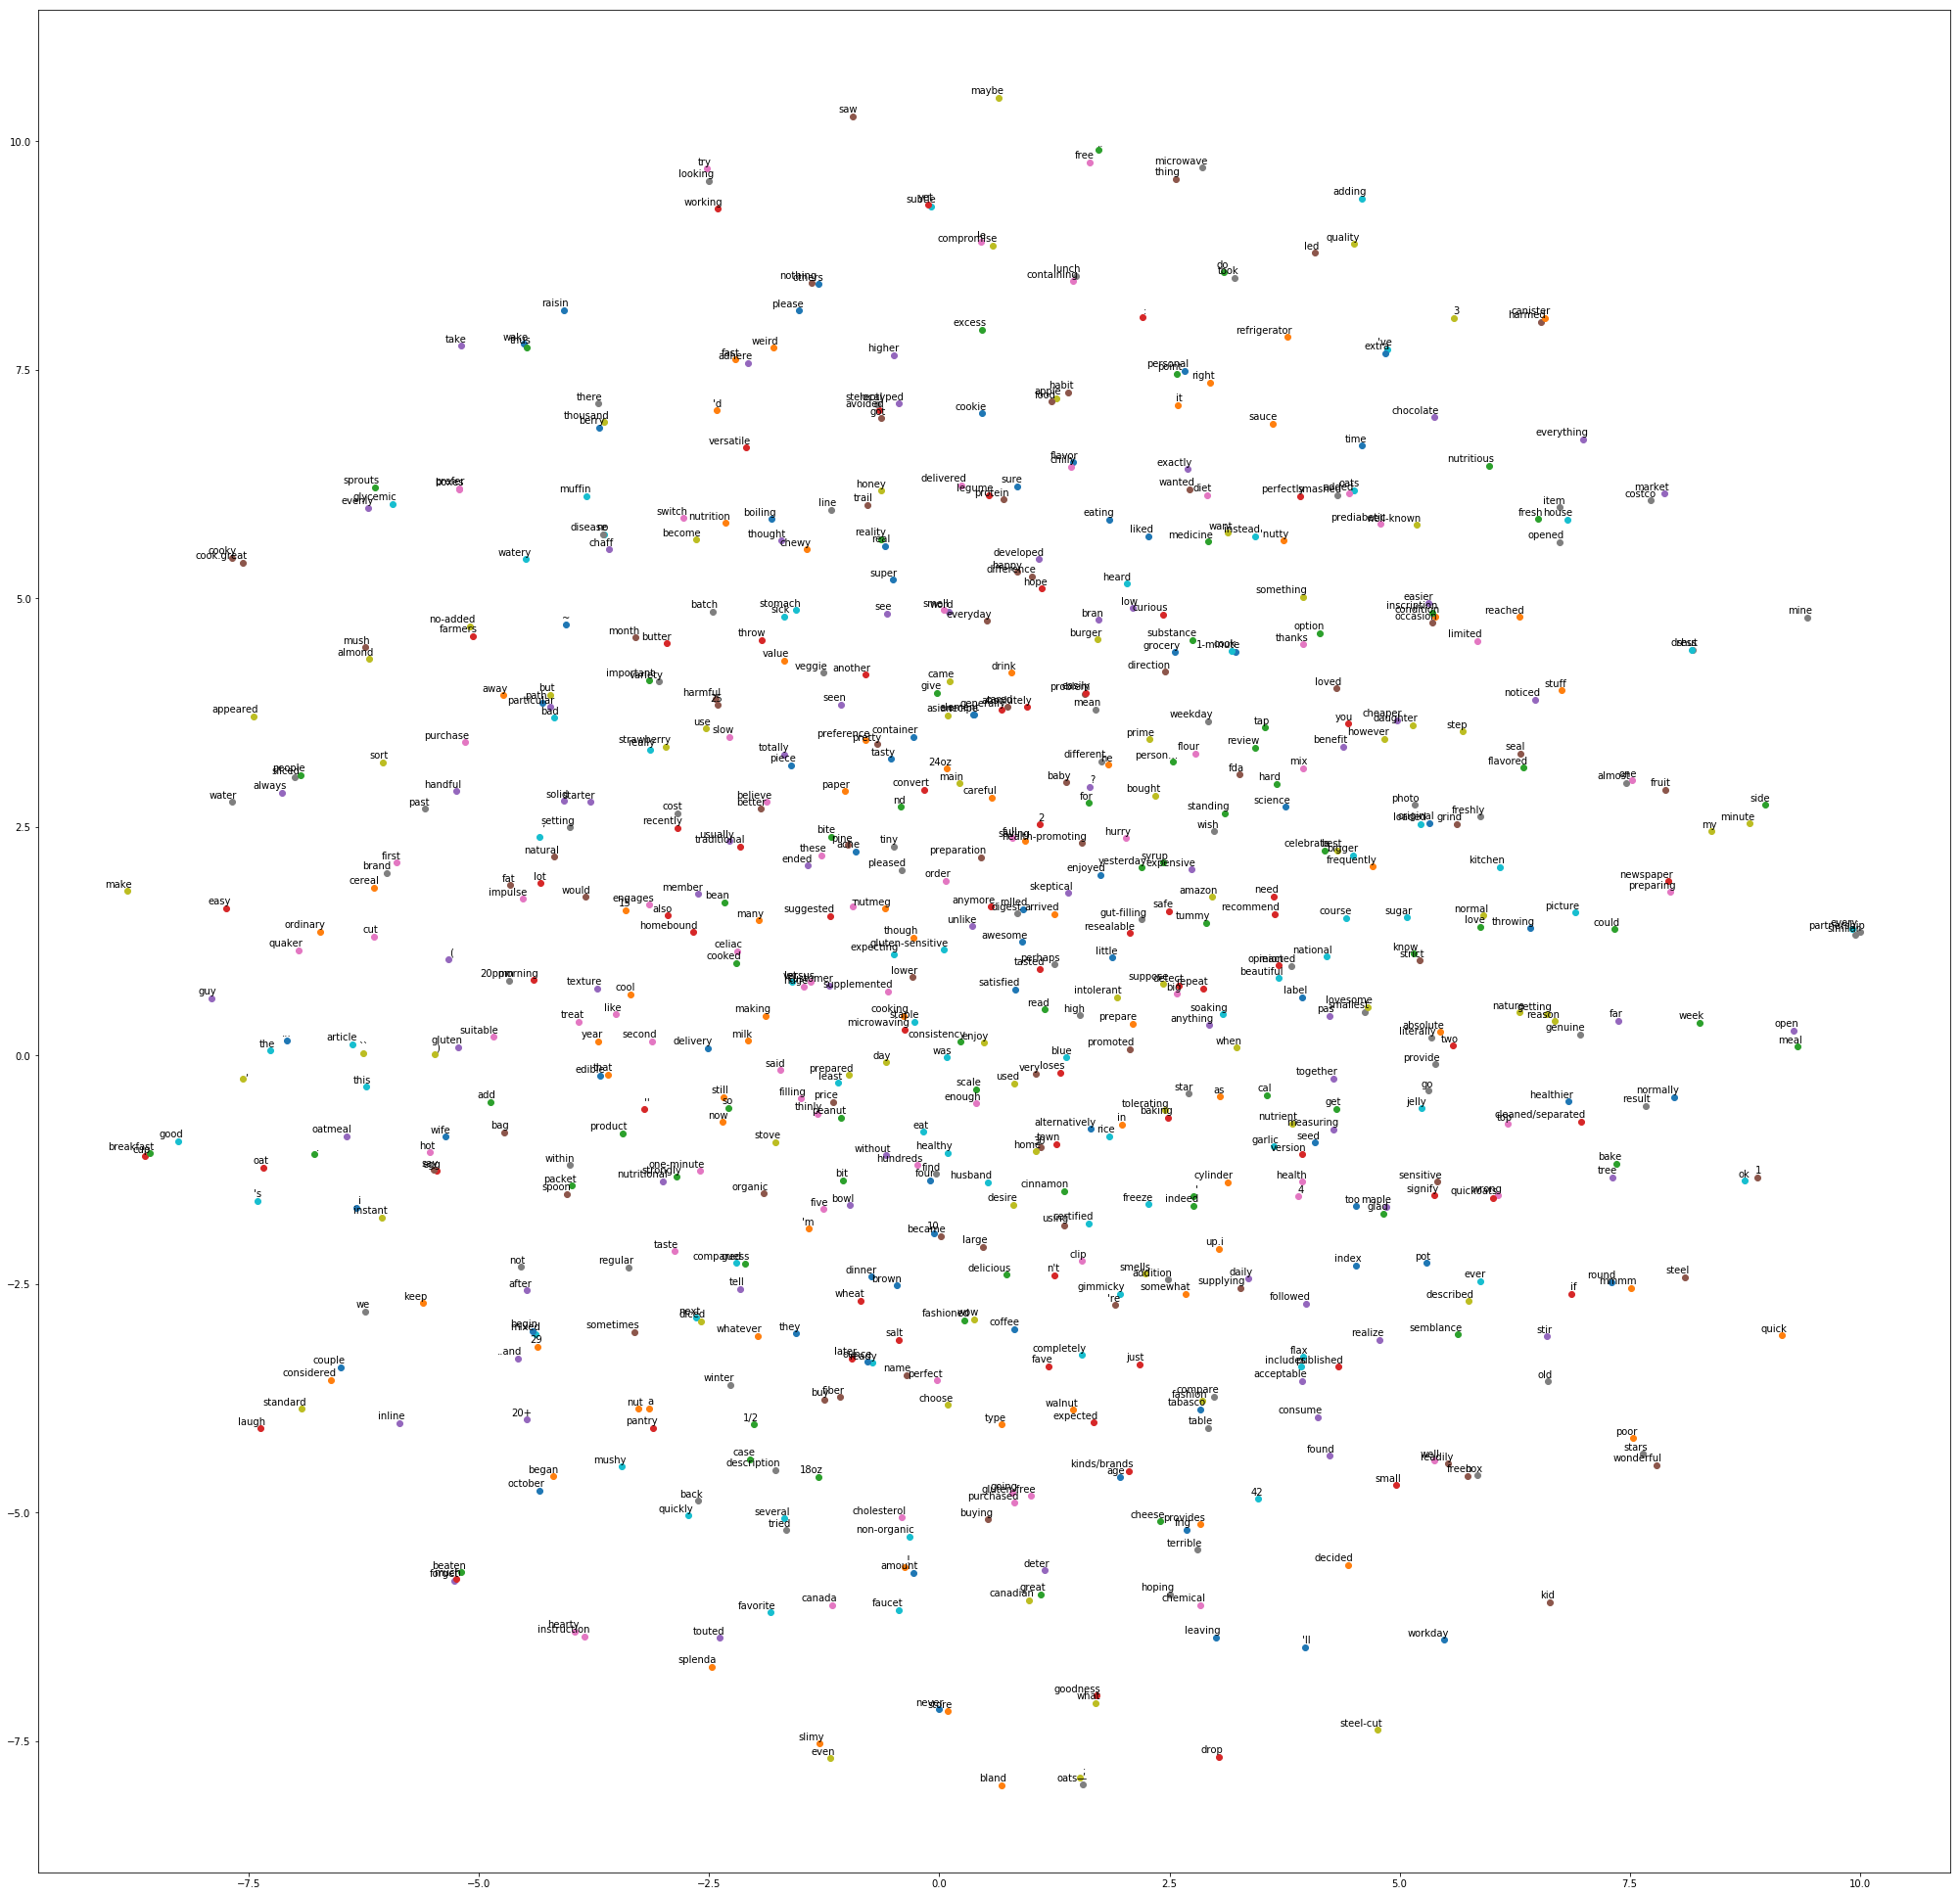

In [19]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


from pylab import figure, axes, pie, title, show

def tsne_plot(model, col):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(35, 35))
    fig = plt.figure(figsize=(35, 35))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    
    
    plt.show()
    
    fig.savefig(col+'.png')
    
tsne_plot(model_dict[key], key)

In [20]:
from sklearn import cluster
from sklearn import metrics

for key in model_dict:
    model = model_dict[key]
    X = model[model.wv.vocab]

    from nltk.cluster import KMeansClusterer
    import nltk
    NUM_CLUSTERS=4
    kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25)
    assigned_clusters = kclusterer.cluster(X, assign_clusters=True)
    print(key)
#     print (assigned_clusters)

    words = list(model.wv.vocab)
    for i, word in enumerate(words):  
        print (word + ":" + str(assigned_clusters[i]))
    
    kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
    kmeans.fit(X)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    print ("Cluster id labels for inputted data")
    print (labels)
    print ("Centroids data")
    print (centroids)

    print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
    print (kmeans.score(X))

    silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')

    print ("Silhouette_score: ")
    print (silhouette_score)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


oatmeal
i:3
keep:1
1/2:2
cup:1
measuring:2
bag:1
clip:1
shut:2
,:2
next:2
coffee:3
stuff:2
.:1
2:0
oatmeal:1
1:3
hot:1
water:3
instant:2
faucet:3
couple:0
splenda:3
bit:1
salt:2
stir:3
spoon:2
--:1
within:3
minute:3
's:1
edible:0
still:0
semblance:3
oat:3
(:0
mush:3
like:2
brand:0
):0
ready:1
raisin:3
nut:0
syrup:1
if:3
forget:2
30:0
second:3
microwave:1
make:1
no:0
little:1
paper:1
packet:2
throw:2
tree:0
harmed:0
le:3
cost:3
day:0
beautiful:2
wife:1
it:3
great:2
morning:2
starter:3
price:2
delivered:2
go:3
home:1
good:3
delivery:0
right:3
nd:1
expected:2
without:2
problem:3
order:3
line:2
amazon:1
this:3
awesome:2
value:2
get:2
lot:3
always:3
loved:0
quaker:0
old:0
fashion:3
favorite:1
they:0
quick:0
breakfast:2
baking:3
unlike:3
very:0
filling:2
provide:2
nutrient:1
mixed:1
flavor:0
a:2
product:2
opinion:1
particular:0
large:2
one:2
box:0
sort:2
expecting:3
round:0
canister:0
case:2
n't:1
deter:2
seal:2
well:1
find:0
use:2
quickly:3
sure:0
'd:0
fashioned:1
version:3
usually:0
buy:3
